# Data Preprocessing, Model Training and Evaluation

- Feature Engineering
- Data Pre-Processing
- Model Training
- Performance comparision of multiple models

## 1. Import data and required packages

### Importing libraries

In [2]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Utilities
from scipy.stats import skew
from scipy.stats.mstats import winsorize

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn.metrics import recall_score, f1_score, precision_score, classification_report, confusion_matrix

# Modelling 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

# Neural Network
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

### Import data as a Pandas DataFrame

In [3]:
df = pd.read_csv('data/BankChurners.csv')
df = df.iloc[:,1:-2]

#### Show last 5 records

In [4]:
df.tail()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
10122,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000
10126,Attrited Customer,43,F,2,Graduate,Married,Less than $40K,Silver,25,6,2,4,10388.0,1961,8427.0,0.703,10294,61,0.649,0.189


## 2. Feature Engineering

In [5]:
df.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

### Columns creation and manipulation

In [6]:
# Income Level
df['Income_Level'] = df['Income_Category'].map({'Less than $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3,
 '$80K - $120K': 4, '$120K +': 5, 'Unknown': 6})

# Card Type Priority
df['Card_Type_Priority'] = df['Card_Category'].map({'Platinum': 4, 'Gold': 3, 'Silver': 2, 'Blue': 1})

# Education Level Priority
df['Education_Level_Priority'] = df['Education_Level'].map({'Doctorate': 7, "Post-Graduate": 6, "Graduate": 5, 
'College': 4, 'High School': 3, 'Uneducated': 2, 'Unknown': 1})

# Products per month
df['Products_year'] = df['Total_Relationship_Count']/df['Months_on_book']*12

# Activity Level
df['Activity_Level'] = np.where((df['Contacts_Count_12_mon'] > 0) & (df['Months_Inactive_12_mon'] == 0), 'Active',
                                np.where((df['Contacts_Count_12_mon'] == 0) & (df['Months_Inactive_12_mon'] > 0), 'Inactive', 'Moderate'))
df['Activity_Level'] = df['Activity_Level'].map({'Active': 1, 'Inactive': 2, 'Moderate': 3})

# Transaction Change Rate
df['Transaction_Amt_Change_Rate'] = (df['Total_Trans_Amt'] - df['Total_Trans_Amt'].shift(1)) / df['Total_Trans_Amt'].shift(1)
df['Transaction_Ct_Change_Rate'] = (df['Total_Trans_Ct'] - df['Total_Trans_Ct'].shift(1)) / df['Total_Trans_Ct'].shift(1)

# Dependent Ratio
df['Dependent_Ratio'] = df['Dependent_count'] / df['Customer_Age']

## 3. Encoding categorical features and correlation map

In [7]:
#Define input features and the target variable
X = df.drop('Attrition_Flag', axis = 1).copy()
y = df['Attrition_Flag'].copy()

In [8]:
# Initiating LabelEncoder
le = LabelEncoder()
# Encoding categorical inputs and target
X_enc = pd.get_dummies(X)
y_enc = pd.Series(le.fit_transform(y), name='Target')
# Create new dataframe with encoding values
df_enc = pd.concat([y_enc, X_enc], axis = 1)

In [9]:
# Correlation matrix of all features
corrmat = df_enc.corr()

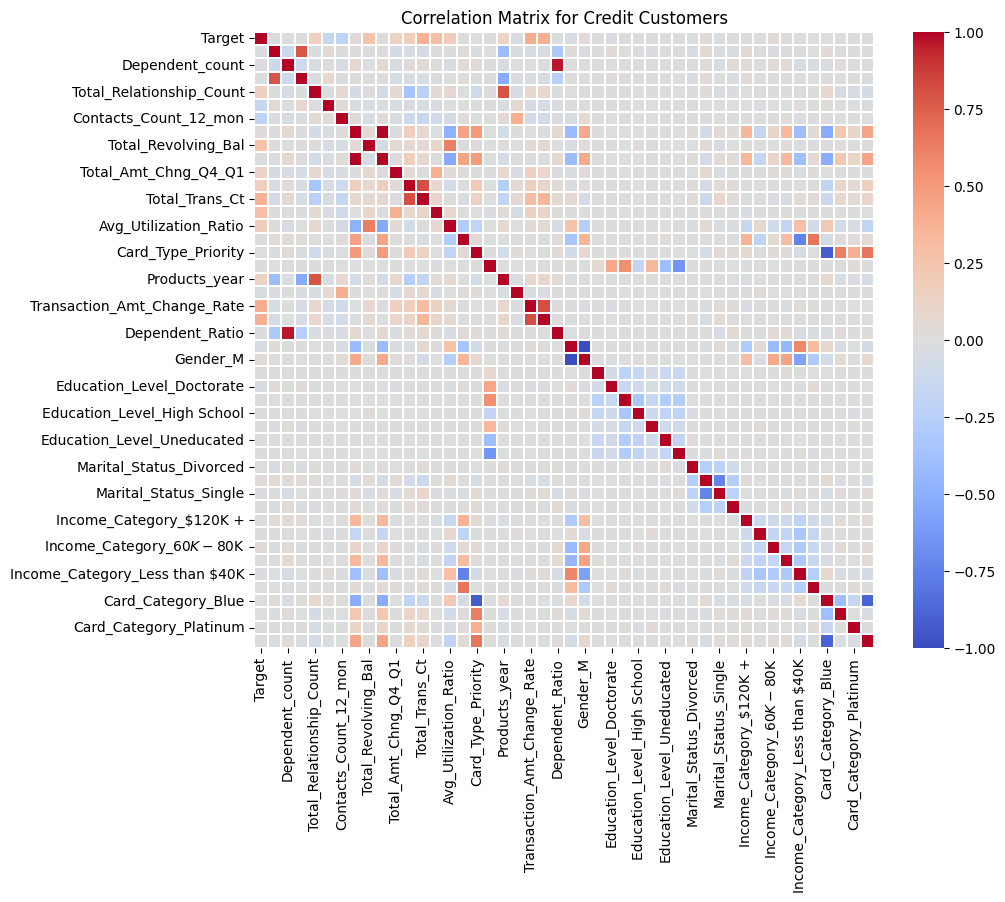

In [10]:
plt.figure(figsize=(10,8))

sns.heatmap(corrmat, cmap = 'coolwarm', annot=False, fmt='.2f', 
            linewidth=.05)
plt.title("Correlation Matrix for Credit Customers")
plt.show()

## 4. Feature Selection and Managing Outliers

### 4.1 Defining target feature and significant correlated features

In [11]:
#Defining target feature
target = 'Target'
#Defining features with significant positive or negative correlation with the target
pos_corr_target_bool = corrmat.loc[target,:].between(0.1,0.65)
neg_corr_target_bool = corrmat.loc[target,:].between(-0.65, -0.1)
target_corr_features = corrmat[target][pos_corr_target_bool | neg_corr_target_bool]

In [12]:
#Print selected significant features and its correlation values with the target
target_corr_features

Total_Relationship_Count       0.150005
Months_Inactive_12_mon        -0.152449
Contacts_Count_12_mon         -0.204491
Total_Revolving_Bal            0.263053
Total_Amt_Chng_Q4_Q1           0.131063
Total_Trans_Amt                0.168598
Total_Trans_Ct                 0.371403
Total_Ct_Chng_Q4_Q1            0.290054
Avg_Utilization_Ratio          0.178410
Products_year                  0.127063
Transaction_Amt_Change_Rate    0.401282
Transaction_Ct_Change_Rate     0.379328
Name: Target, dtype: float64

### 4.2 Handling Outliers of the Selected Features

In [13]:
input_df = pd.DataFrame()

# Loop through each column of the selected features
for col in target_corr_features.index:
    # Determine the skewness of the distribution
    skewness = skew(df_enc[col])
    
    # Decide on winsorization limits based on the skewness
    if skewness > 1:
        # Right-skewed distribution: more aggressive on the higher end
        lower_limit, upper_limit = 0.05, 0.25
    elif skewness < -1:
        # Left-skewed distribution: more aggressive on the lower end
        lower_limit, upper_limit = 0.25, 0.05
    else:
        # Symmetrical or mildly skewed: balanced treatment
        lower_limit, upper_limit = 0.15, 0.15
    
    # Apply winsorization with dynamic, skewness-based limits
    winsorized_values = winsorize(df_enc[col], limits=(lower_limit, upper_limit))
    
    # Assign the winsorized values to the new DataFrame
    input_df[col] = winsorized_values.copy()

### 4.3 Scaling model inputs, partitioning into training and test sets

In [14]:
# Initialize LabelEncoder
#ohe = OneHotEncoder()
ss = StandardScaler()
# Column Transformer with two types of transformers
preprocessor = ColumnTransformer(
    [
        #("OneHotEncoder", ohe, cat_features),
        ("StandardScaler", ss, input_df.columns)
    ]
)

In [15]:
X_input = preprocessor.fit_transform(input_df)
y_input = np.array(y_enc)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size = 0.20)

## 5. Modeling and Evaluation

### 5.1 Classic models

In [17]:
#Classifier Metrics
df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score', 'Confusion Matrix'])

In [18]:
#Machine Learning Classifier Training and Validating
def get_perf_metrics(model, i):
    model_name = type(model).__name__
    print("Training {} model...".format(model_name))
    model.fit(X_train, y_train)
    print("Completed {} model training.".format(model_name))
    y_pred = model.predict(X_test)

    df_perf_metrics.loc[i] = [
        model_name,
        model.score(X_train, y_train),
        model.score(X_test, y_test),
        precision_score(y_test, y_pred, average = 'macro'),
        recall_score(y_test, y_pred, average = 'macro'),
        f1_score(y_test, y_pred, average = 'macro'),
        confusion_matrix(y_test, y_pred)
    ]
   
    print("Completed {} model's performance assessment.".format(model_name))
models_list = [LogisticRegression(max_iter=3000),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               SVC(),
               KNeighborsClassifier(),
               GaussianNB(),
               LinearDiscriminantAnalysis()
               ]

In [19]:
#Training, prediciting and validating process
for n, model in enumerate(models_list):

    get_perf_metrics(model, n)

Training LogisticRegression model...
Completed LogisticRegression model training.
Completed LogisticRegression model's performance assessment.
Training DecisionTreeClassifier model...
Completed DecisionTreeClassifier model training.
Completed DecisionTreeClassifier model's performance assessment.
Training RandomForestClassifier model...
Completed RandomForestClassifier model training.
Completed RandomForestClassifier model's performance assessment.
Training SVC model...
Completed SVC model training.
Completed SVC model's performance assessment.
Training KNeighborsClassifier model...
Completed KNeighborsClassifier model training.
Completed KNeighborsClassifier model's performance assessment.
Training GaussianNB model...
Completed GaussianNB model training.
Completed GaussianNB model's performance assessment.
Training LinearDiscriminantAnalysis model...
Completed LinearDiscriminantAnalysis model training.
Completed LinearDiscriminantAnalysis model's performance assessment.


### Results

In [20]:
#Comparative classification models dataframe
df_perf_metrics

,Model,Accuracy_Training_Set,Accuracy_Test_Set,Precision,Recall,f1_score,Confusion Matrix
0,LogisticRegression,0.932354,0.924975,0.866962,0.831007,0.847514,"[[215, 94], [58, 1659]]"
1,DecisionTreeClassifier,1.000000,0.938796,0.887654,0.871006,0.879039,"[[239, 70], [54, 1663]]"
2,RandomForestClassifier,1.000000,0.961500,0.940330,0.906959,0.922633,"[[256, 53], [25, 1692]]"
3,SVC,0.960005,0.946693,0.919227,0.866377,0.890077,"[[232, 77], [31, 1686]]"
4,KNeighborsClassifier,0.954574,0.932379,0.888045,0.838028,0.860357,"[[217, 92], [45, 1672]]"
5,GaussianNB,0.872115,0.870188,0.755673,0.838490,0.785505,"[[245, 64], [199, 1518]]"
6,LinearDiscriminantAnalysis,0.926552,0.920533,0.852293,0.832366,0.841860,"[[218, 91], [70, 1647]]"


### 5.2 Neural Network model

In [21]:
#One-Hot Encoding Target sets
y_train=pd.get_dummies(y_train)
y_test=pd.get_dummies(y_test)

In [ ]:
# Neural network model with three neuron layers and a dropout layer
model_cnn = Sequential([
    Dense(256, activation='relu', input_shape=[X_train.shape[1]]),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile the model with a potential for early stopping and learning rate decay
opt = Adam(learning_rate=0.001) 

model_cnn.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['binary_accuracy'])

# Early stopping to avoid overfitting, with a patience parameter to wait for 'n' epochs after the last best score
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# The summary of the neural network is shown
model_cnn.summary()

# Train the model with validation split and early stopping
history = model_cnn.fit(X_train, y_train, 
                        epochs=100,
                        batch_size=32,
                        verbose=1, 
                        validation_split=0.2,
                        callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3328      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 69634 (272.01 KB)
Trainable params: 69634 (272.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
203/203 [==============================] - 10s 19ms/step - loss: 0.2330 - binary_accuracy: 0.9077 - val_loss: 0.1932 - val_binary_accuracy

### Results

In [23]:
train_loss, acc_train = model_cnn.evaluate(X_train,  y_train, verbose = 0)
print(f'Train Accuracy: {acc_train:.4f}')

test_loss, acc_test = model_cnn.evaluate(X_test,  y_test, verbose = 0)
print(f'Test Accuracy: {acc_test:.4f}')

Train Accuracy: 0.9733
Test Accuracy: 0.9615


In [24]:
y_pred_train=model_cnn.predict(X_train, verbose = 0)
y_pred_test=model_cnn.predict(X_test, verbose = 0)
#The classification reports of the model are shown
print('Train NN \n',classification_report(y_train.values.argmax(axis=1),y_pred_train.argmax(axis=1),zero_division=True))
print('Test NN \n',classification_report(y_test.values.argmax(axis=1),y_pred_test.argmax(axis=1),zero_division=True))

Train NN 
               precision    recall  f1-score   support

           0       0.93      0.90      0.92      1318
           1       0.98      0.99      0.98      6783

    accuracy                           0.97      8101
   macro avg       0.96      0.94      0.95      8101
weighted avg       0.97      0.97      0.97      8101

Test NN 
               precision    recall  f1-score   support

           0       0.89      0.85      0.87       309
           1       0.97      0.98      0.98      1717

    accuracy                           0.96      2026
   macro avg       0.93      0.91      0.92      2026
weighted avg       0.96      0.96      0.96      2026



In [25]:
#Confusion Matrices
print("Train NN \n", confusion_matrix(y_train.values.argmax(axis=1), y_pred_train.argmax(axis=1)))
print("Test NN \n", confusion_matrix(y_test.values.argmax(axis=1), y_pred_test.argmax(axis=1)))

Train NN 
 [[1185  133]
 [  83 6700]]
Test NN 
 [[ 262   47]
 [  31 1686]]
